In [3]:
import cv2
import matplotlib.pyplot as plt
import torch

import Inference
import Filter
import rrrc_cpp

# https://github.com/qbxlvnf11/convert-pytorch-onnx-tensorrt/blob/TensorRT-21.08/convert_onnx_to_tensorrt/convert_onnx_to_tensorrt.py

In [4]:
img = cv2.imread("/home/artl2sch/Desktop/Robotic_Perception/C++/FastCropRotate/0-0.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, [2000, 2000])

In [5]:
out_n = 250

with torch.no_grad():    

    input_image  =  torch.tensor(img, dtype = torch.uint8)[None, :, :].contiguous().cuda()
    output_images = torch.zeros([out_n, 1, 128, 128], dtype = torch.float32).contiguous().cuda()

    M = torch.tensor([1.0, 0.0, 0.0, 1.0]*out_n, dtype = torch.float32)
    M_rand = torch.rand_like(M)
    M += M_rand * 0.5

    M *= input_image.shape[-1]/output_images.shape[-1]
    T = torch.tensor([0.0, 0.0]*out_n, dtype = torch.float32)

In [6]:
'''import SimCLR
import yaml
import time
import torch
with open('./config.yaml') as f:
    config = yaml.load(f, Loader=yaml.Loader)

model = SimCLR.load_saved_model(config)
model.to('cuda')
model.eval()

#output_images = torch.zeros([500, 1, 128, 128], dtype = torch.float32).contiguous().cuda()

'''

"import SimCLR\nimport yaml\nimport time\nimport torch\nwith open('./config.yaml') as f:\n    config = yaml.load(f, Loader=yaml.Loader)\n\nmodel = SimCLR.load_saved_model(config)\nmodel.to('cuda')\nmodel.eval()\n\n#output_images = torch.zeros([500, 1, 128, 128], dtype = torch.float32).contiguous().cuda()\n\n"

In [7]:
'''t = 0
for i in range(100):
    output_images = torch.rand([400, 1, 128, 128], dtype = torch.float32).cuda()

    t -= time.time()
    output_images_3 = output_images.repeat(1, 3, 1, 1)
    model_out = model(output_images_3)
    t += time.time()

    del output_images
    del output_images_3


    torch.cuda.empty_cache()

print (t/100)'''

't = 0\nfor i in range(100):\n    output_images = torch.rand([400, 1, 128, 128], dtype = torch.float32).cuda()\n\n    t -= time.time()\n    output_images_3 = output_images.repeat(1, 3, 1, 1)\n    model_out = model(output_images_3)\n    t += time.time()\n\n    del output_images\n    del output_images_3\n\n\n    torch.cuda.empty_cache()\n\nprint (t/100)'

In [8]:
ONNX_FILE_PATH = './Weights/model.onnx'
with torch.no_grad():    
    trt_model = Inference.TRTModel(out_n, ONNX_FILE_PATH)
    trt_model.build_engine()
    trt_model.reserve_cuda_memory()

[07/01/2023-23:27:18] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading
[07/01/2023-23:27:18] [TRT] [W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
inputTensor.name: input
[07/01/2023-23:27:46] [TRT] [W] TensorRT encountered issues when converting weights between types and that could affect accuracy.
[07/01/2023-23:27:46] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to adjust the magnitude of the weights.
[07/01/2023-23:27:46] [TRT] [W] Check verbose logs for the list of affected weights.
[07/01/2023-23:27:46] [TRT] [W] - 24 weights are affected by this issue: Detected subnormal FP16 values.
[07/01/20

In [9]:
with torch.no_grad():
    pf = Filter.ParticleFilter(out_n)
    displacement_val = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype = torch.float32).cuda()
    displacement_var = torch.tensor([0.5, 0.0, 0.0, 0.2], dtype = torch.float32).cuda()

In [468]:
from MapLoader import MapVector, Map
import torch
import numpy as np
import math

def geodesic2ecef_torch(lla):
    # https://www.mathworks.com/help/aeroblks/llatoecefposition.html

    a = 6378137.0
    b = 6356752.314245
    e = math.sqrt(1 - (b/a)**2)
    e2 = e**2
    ep = math.sqrt((a/b)**2 - 1)
    ep2 = ep**2

    N = a / math.sqrt(1 - e2 * torch.sin(lla[:,0]*np.pi/180)**2)
    X = (N + lla[:,2]) * torch.cos(lla[:,0]*np.pi/180) * torch.cos(lla[:,1]*np.pi/180)
    Y = (N + lla[:,2]) * torch.cos(lla[:,0]*np.pi/180) * torch.sin(lla[:,1]*np.pi/180)
    Z = (N * (1 - e2) + lla[:,2]) * torch.sin(lla[:,0]*np.pi/180)

    return torch.stack([X, Y, Z], dim = 1)

def ecef2geodesic_torch(ecef):

    a = 6378137.0
    b = 6356752.314245
    e2 = 1 - (b/a)**2
    e2_2 = (a/b)**2 - 1

    p = torch.sqrt(ecef[:,0]**2 + ecef[:,1]**2)
    F = 54 * b**2 * ecef[:,2]**2
    G = p**2 + (1 - e2) * ecef[:,2]**2 - e2 * (a**2 - b**2)
    c = (e2**2 * F * p**2) / (G**3)
    s = (1 + c + torch.sqrt(c**2 + 2 * c))**(1/3)
    k = s + 1/s + 1
    P = F/(3*k**2 * G**2)
    Q = torch.sqrt(1 + 2 * e2_2**2 * P)
    r0 = -(P * e2 * p)/(1 + Q) + torch.sqrt(0.5 * a**2 * (1 + 1/Q) - P * (1 - e2) * ecef[:,2]**2 / (Q * (1 + Q)) - 0.5 * P * p**2)
    U = torch.sqrt((p - e2 * r0)**2 + ecef[:,2]**2)
    V = torch.sqrt((p - e2 * r0)**2 + (1 - e2) * ecef[:,2]**2)
    z0 = (b**2 * ecef[:,2])/(a * V) 
    h = U * (1 - b**2/(a * V))
    fi = torch.atan((ecef[:,2] + e2_2 * z0)/p)
    lambd = torch.atan2(ecef[:,1], ecef[:,0])

    return torch.stack([fi*180/np.pi, lambd*180/np.pi, h], dim = 1)

def ecef2ned_torch(ecef, lla0):

    
    slat = torch.sin(lla0[:,0]*np.pi/180)
    clat = torch.cos(lla0[:,0]*np.pi/180)
    slon = torch.sin(lla0[:,1]*np.pi/180)
    clon = torch.cos(lla0[:,1]*np.pi/180)

    R = torch.tensor([[-slat*clon, -slat*slon, clat],
                      [-slon,       clon,       0],
                      [-clat*clon, -clat*slon, -slat]], dtype = torch.float64)
    
    
    ecef0 = geodesic2ecef_torch(lla0)

    ecef = ecef - ecef0

    ned = torch.zeros_like(ecef)
    ned[:, 0] = R[0, 0] * ecef[:, 0] + R[0, 1] * ecef[:, 1] + R[0, 2] * ecef[:, 2]
    ned[:, 1] = R[1, 0] * ecef[:, 0] + R[1, 1] * ecef[:, 1] + R[1, 2] * ecef[:, 2]
    ned[:, 2] = R[2, 0] * ecef[:, 0] + R[2, 1] * ecef[:, 1] + R[2, 2] * ecef[:, 2]


    return ned

def ned2ecef_torch(ned, lla0):
    # https://www.mathworks.com/help/aeroblks/llatoecefposition.html

    slat = np.sin(lla0[:,0]*np.pi/180)
    clat = np.cos(lla0[:,0]*np.pi/180)
    slon = np.sin(lla0[:,1]*np.pi/180)
    clon = np.cos(lla0[:,1]*np.pi/180)

    R = torch.tensor([[-slat*clon, -slat*slon, clat],
                        [-slon,       clon,       0],
                        [-clat*clon, -clat*slon, -slat]], dtype = torch.float64)
    
    ecef0 = geodesic2ecef_torch(lla0)

    ecef = torch.zeros_like(ned)
    ecef[:, 0] = R[0, 0] * ned[:, 0] + R[1, 0] * ned[:, 1] + R[2, 0] * ned[:, 2]
    ecef[:, 1] = R[0, 1] * ned[:, 0] + R[1, 1] * ned[:, 1] + R[2, 1] * ned[:, 2]
    ecef[:, 2] = R[0, 2] * ned[:, 0] + R[1, 2] * ned[:, 1] + R[2, 2] * ned[:, 2]

    ecef = ecef + ecef0

    return ecef

In [474]:


lla0 = torch.tensor([[ 31.884542,  34.961650,  0]],  dtype = torch.float64)

ned = torch.tensor([[ 100000,  100000,  300]],  dtype = torch.float64)

ecef = ned2ecef_torch(ned, lla0)

lla1 = ecef2geodesic_torch(ecef)
print( "lla1 = ", lla1.cpu().numpy().tolist() )

ecef = geodesic2ecef_torch(lla1)

ned = ecef2ned_torch(ecef, lla0)
print( "ned = ", ned.cpu().numpy().tolist() )


lla1 =  [[32.78173570746824, 36.02893309792282, 1270.0055308489498]]
ned =  [[100000.00003550114, 100000.00004392052, 299.9972014245868]]


In [452]:
import pymap3d as pm

lla0 = torch.tensor([ 31.884542,  34.961650,  0],  dtype = torch.float64)

ned = torch.tensor([[ 100000,  100000,  300]],  dtype = torch.float64)


print ('lla : ', lla0)

ecef0 = pm.geodetic2ecef(lla0[0], lla0[1], lla0[2])

print ('ecef : ', ecef0)

lla1 = pm.ecef2geodetic(ecef0[0], ecef0[1], ecef0[2])

print ('lla : ', lla1)


lla :  tensor([31.8845, 34.9616,  0.0000], dtype=torch.float64)
ecef :  (tensor(4442565.4649, dtype=torch.float64), tensor(3106288.4356, dtype=torch.float64), tensor(3349567.3406, dtype=torch.float64))
lla :  (31.884542000000003, 34.96165, -1.041250292910165e-09)


In [379]:
n_steps = 70

import time


loop_time = -time.time()

rrrc_time = 0
pf_time = 0
model_time = 0

for i in range(n_steps):
    with torch.no_grad():    

        rrrc_time -= time.time()
        rrrc_cpp.rrrc(input_image, output_images, M, T)
        rrrc_time += time.time()

        model_time -= time.time()
        output_images_3 = output_images.repeat(1, 3, 1, 1)
        embeddings = trt_model.run(output_images_3)
        model_time += time.time()

        pf_time -= time.time()
        #pf.resample(embeddings) # add weighted average for particles
        pf.move(displacement_val, displacement_var) # should be parallel with the loop
        pf_time += time.time()



loop_time += time.time()

loop_time /= n_steps
rrrc_time /= n_steps
model_time /= n_steps
pf_time /= n_steps

print ("loop  time : ", loop_time)
print ("rrrc  time : ", rrrc_time)
print ("model time : ", model_time)
print ("pf    time : ", pf_time)

NameError: name 'rrrc_cpp' is not defined

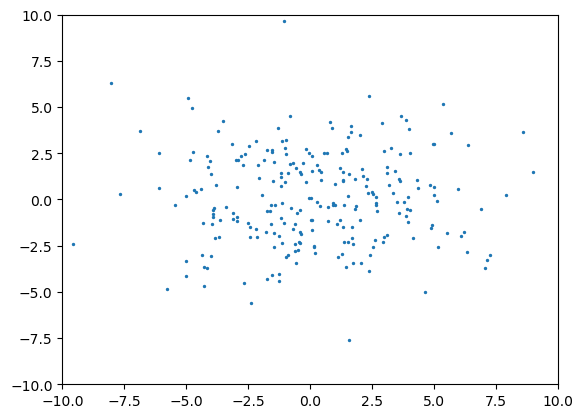

In [10]:
pf.draw_particles()
#pf.print_times()

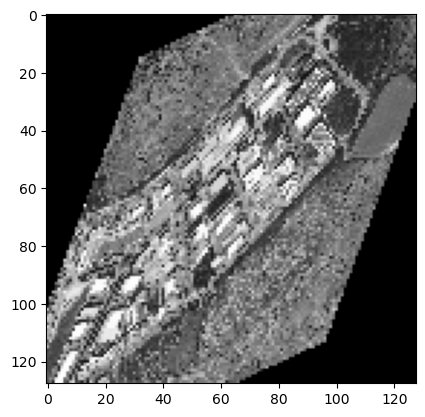

In [10]:
import numpy as np
plt.imshow(output_images_3[2].cpu().numpy().swapaxes(0, 2).astype(np.uint8))

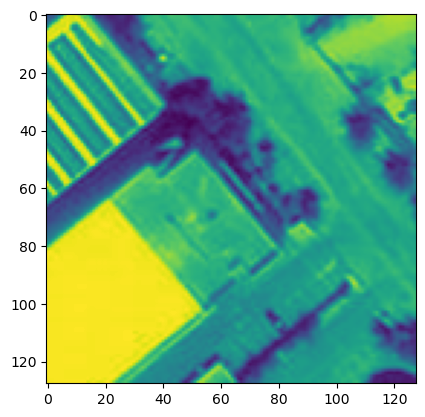

In [48]:
plt.imshow(input_image.cpu()[:, 1000:1128:1, 1000:1128:1].numpy().swapaxes(0, 2))

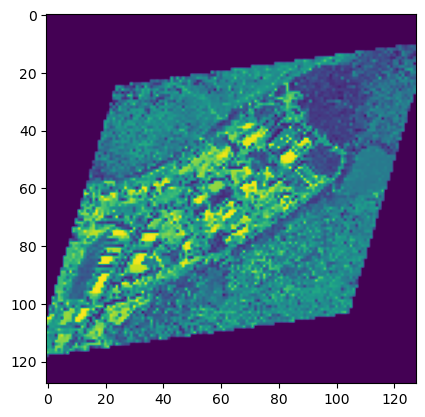

In [54]:
image = output_images[2].cpu().numpy().swapaxes(0, 2)

plt.imshow(output_images[2].cpu().numpy().swapaxes(0, 2))

In [53]:
image_3 = output_images_3[2].cpu().numpy().swapaxes(0, 2)

In [52]:
image_3.mean(), image.mean()

(70.88257, 70.88257)